# Code to Solve the Image Deblurring Problem

## Problem formulation

$\boldsymbol{y} = \boldsymbol{S} \left( \boldsymbol{b} \circledast \boldsymbol{x} + \boldsymbol{\varepsilon} \right) = \boldsymbol{S} \left( \mathcal{C} (\boldsymbol{b})\boldsymbol{x} + \boldsymbol{\varepsilon} \right), \hspace{2ex} \boldsymbol{\varepsilon} \sim \mathcal{N} (0, \sigma^2 \boldsymbol{I}), \hspace{2ex} \sigma \geq 0.$

- $\boldsymbol{x} \in \mathbb{R}^{n}$: (vectorized) unknown image to recover 
- $\boldsymbol{b} \in \mathbb{R}^{n}$: (vectorized) blurring kernel
- $\mathcal{C}(\boldsymbol{b})$ : circulant matrix of $\boldsymbol{b}$
- $\boldsymbol{\varepsilon} \in \mathbb{R}^{m}$: noise
- $ \sigma \in \mathbb{R}^+$: noise level 
- $ \boldsymbol{y} \in \mathbb{R}^{n}$: observed measurements
- $ \circledast : \mathbb{R}^{n} \times \mathbb{R}^{n} \mapsto \mathbb{R}^{n}$: denotes cicular convolution (https://en.wikipedia.org/wiki/Convolution)
- $ \boldsymbol{S} \in \mathbb{R}^{m} \times \mathbb{R}^{n}$: subsampling matrix

## Loss function, gradients

### Loss function:

$\ell ({\boldsymbol{x}}) = \frac{1}{2m} \| \boldsymbol{y} - \boldsymbol{S} \mathcal{C} (\boldsymbol{b})\boldsymbol{x} \|_2^2$

### Loss function as a finite sum:

$\ell (\boldsymbol{x}) := \frac{1}{m} \sum_i^m \ell_{i}(\boldsymbol{x}) = \frac{1}{m}\sum_i^m \frac{1}{2}(y_i - \mathcal{C}_i(\boldsymbol{b}) \boldsymbol{x})^2$

- $\mathcal{C}_i(\boldsymbol{b})$ denotes the $i^{\text{th}}$ row of the circulant matrix of $\boldsymbol{b}$

### Full gradient:

$\nabla \ell ({\boldsymbol{x}}) = \frac{1}{m} \mathcal{C} (\boldsymbol{b})^\top \boldsymbol{S}^\top  ( \boldsymbol{S} \mathcal{C} (\boldsymbol{b}) \boldsymbol{x} - \boldsymbol{y} ) $

### Stochastic gradient:

$\nabla \ell_{i}({\boldsymbol{x}}) = \boldsymbol{S}^\top_i \mathcal{C} (\boldsymbol{b})^\top_i (\boldsymbol{x}^\top \mathcal{C}_i(\boldsymbol{b}) - y_i ) $



In [1]:
%matplotlib inline 

from imports import *
import pylops

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# No Subsampling --> Perfect Recovery?

(512, 512)
c:\Users\14807\Documents\GitHub\pnp-svrg\.venv\lib\site-packages\skimage\metrics\simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


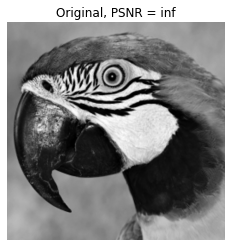

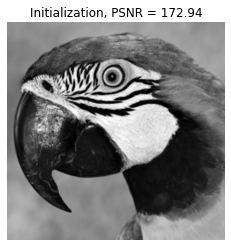

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

height = 512
width = 512

problem = Deblur(img_path='./data/Set12/07.png', kernel_path='./deblurring/kernel.png', H=height, W=width, sigma=.0,  scale_percent=100, lr_decay=1.0)
psnr_display(img_path='./data/Set12/07.png', output=problem.original, title="Original", H=height, W=width)

noisy = problem.noisy
print(noisy.shape)

psnr_display(img_path='./data/Set12/07.png', output=noisy, title="Initialization", H=height, W=width)

(-0.5, 511.5, 511.5, -0.5)

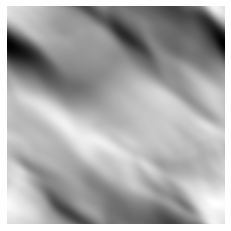

In [3]:
measurements = problem.y
measurements = (measurements - measurements.min()) / (measurements.max() - measurements.min())

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(measurements, cmap='gray', vmin=0, vmax=1)
ax.axis('off')

In [5]:
denoiser = NLMDenoiser(filter_decay=0.99,
                       filter_size=0.000, patch_size=5, patch_distance=6, multichannel=True)

svrg_out, svrg_time, svrg_psnr, svrg_zs = pnp_gd(problem=problem,
                                                   denoiser=denoiser,
                                                   eta=2.5e-11, tt=10, verbose=True)

0 Before denoising:  189.302756027337
0 After denoising:  189.30276883292385
1 Before denoising:  184.99224446677033
1 After denoising:  184.99224730271064
2 Before denoising:  180.51010068052227
2 After denoising:  180.5101020538134
3 Before denoising:  175.97503503657288
3 After denoising:  175.97503454873177
4 Before denoising:  171.42281282793635
4 After denoising:  171.42281413841863
5 Before denoising:  166.8648420553048
5 After denoising:  166.86484296872717
6 Before denoising:  162.30483971209316
6 After denoising:  162.30484081599707
7 Before denoising:  157.74405316286635
7 After denoising:  157.74405392146474
8 Before denoising:  153.1829163059479
8 After denoising:  153.18291782513379
9 Before denoising:  148.62159293459592
9 After denoising:  148.62159283975222
10 Before denoising:  144.06014768318397
10 After denoising:  144.06014765145608
11 Before denoising:  139.4986145539318
11 After denoising:  139.49861511898885
12 Before denoising:  134.9370122097354
12 After denoi

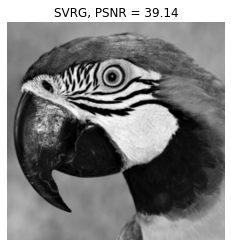

In [6]:
psnr_display(img_path='./data/Set12/07.png', output=svrg_out.reshape(height,width), title="SVRG", H=512, W=512)

(Compare with simply inverting/deblurring)

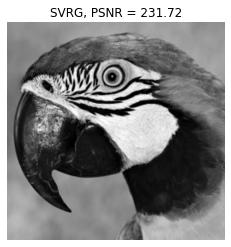

In [7]:
H, W = 512, 512
Y = fft_blur(problem.original, problem.blur)
Xhat = np.real(np.fft.ifft( np.fft.fft(problem.y.reshape(512,512).flatten())/np.fft.fft(problem.blur.flatten()) )).reshape(H,W) * H * W

psnr_display(img_path='./data/Set12/07.png', output=Xhat.reshape(problem.dim_old), title="SVRG", H=512, W=512)

# Only super resolution, no deblurring

c:\Users\14807\Documents\GitHub\pnp-svrg\.venv\lib\site-packages\skimage\metrics\simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


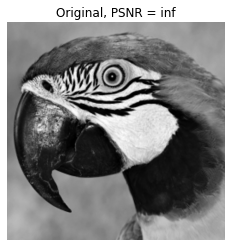

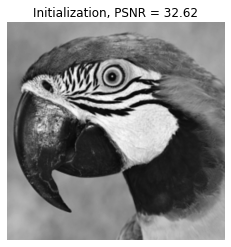

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

height = 512
width = 512
scaling = 50

problem = Deblur(img_path='./data/Set12/07.png', kernel="Identity", H=height, W=width, sigma=0., scale_percent=scaling, lr_decay=0.99)
psnr_display(img_path='./data/Set12/07.png', output=problem.original, title="Original", H=height, W=width)

noisy = problem.noisy
noisy = (noisy - noisy.min()) / (noisy.max() - noisy.min())
# print(noisy)

psnr_display(img_path='./data/Set12/07.png', output=noisy, title="Initialization", H=height, W=width)

(-0.5, 255.5, 255.5, -0.5)

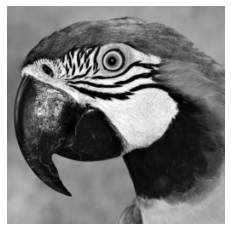

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

measurements = problem.y
measurements = (measurements - measurements.min()) / (measurements.max() - measurements.min())

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(measurements, cmap='gray', vmin=0, vmax=1)
ax.axis('off')

In [8]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


denoiser = BM3DDenoiser(filter_decay=0.1, noise_est=0.001)
svrg_out, svrg_time, svrg_psnr, svrg_zs = pnp_gd(problem=problem,
                                                   denoiser=denoiser,
                                                   eta=1e10, tt=60, verbose=True)

0 Before denoising:  42.687792379806694
0 After denoising:  42.68450090507966
1 Before denoising:  42.71821133877579
1 After denoising:  42.7181273932746
2 Before denoising:  42.74846625187861
2 After denoising:  42.74846386751893
3 Before denoising:  42.775760518981684
3 After denoising:  42.77575972433675
4 Before denoising:  42.800340034791915
4 After denoising:  42.80033975371417
5 Before denoising:  42.822493823249914
5 After denoising:  42.822492355515934
6 Before denoising:  42.84247802288324
6 After denoising:  42.842476957683886
7 Before denoising:  42.86052332027574
7 After denoising:  42.86052371514028
8 Before denoising:  42.8768343556318
8 After denoising:  42.87683356252387
9 Before denoising:  42.89158959622248
9 After denoising:  42.89158942545227
10 Before denoising:  42.90495189018551
10 After denoising:  42.904952000090745
11 Before denoising:  42.917064191959646
11 After denoising:  42.91706415965499


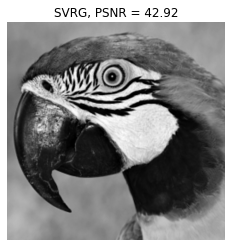

In [9]:
psnr_display(img_path='./data/Set12/07.png', output=svrg_out.reshape(height,width), title="SVRG", H=512, W=512)

# Super resolution and deblurring

[[0.75975742 0.59256268 0.6422799  ... 0.63158069 0.55927031 0.6789765 ]
 [0.64355453 0.17274263 0.61964949 ... 0.69625879 0.30541111 0.77751993]
 [0.3793225  0.85696173 0.64265369 ... 0.47992295 0.54575436 0.62280305]
 ...
 [0.47900053 1.         0.69485232 ... 0.55325758 0.7199129  0.76003689]
 [0.65273986 0.60463399 0.56699576 ... 0.68411288 0.78401018 0.65342898]
 [0.6693941  0.59401559 0.5288536  ... 0.82389459 0.78232342 0.32937341]] 0.0 1.0
c:\Users\14807\Documents\GitHub\pnp-svrg\.venv\lib\site-packages\skimage\metrics\simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


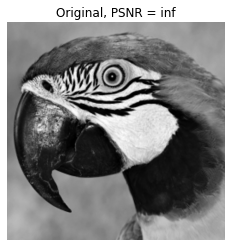

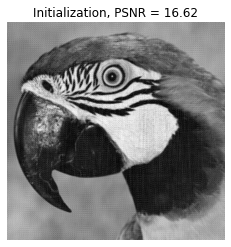

In [10]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

height = 512
width = 512
scaling = 80

problem = Deblur(img_path='./data/Set12/07.png', kernel_path='./deblurring/kernel.png', H=height, W=width, sigma=0., scale_percent=scaling, lr_decay=1)
psnr_display(img_path='./data/Set12/07.png', output=problem.original, title="Original", H=height, W=width)

noisy = problem.noisy
noisy = np.clip(noisy, 0, 1)
# noisy = (noisy - noisy.min()) / (noisy.max() - noisy.min())
print(noisy, noisy.min(), noisy.max())

psnr_display(img_path='./data/Set12/07.png', output=noisy, title="Initialization", H=height, W=width)

(-0.5, 408.5, 408.5, -0.5)

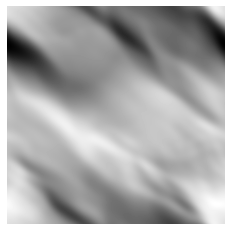

In [11]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

measurements = problem.y
measurements = (measurements - measurements.min()) / (measurements.max() - measurements.min())

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(measurements, cmap='gray', vmin=0, vmax=1)
ax.axis('off')

In [27]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

denoiser = BM3DDenoiser(filter_decay=0.9, noise_est=0.01)
svrg_out, svrg_time, svrg_psnr, svrg_zs = pnp_gd(problem=problem,
                                                   denoiser=denoiser,
                                                   eta=5, tt=600, verbose=True)                                           

0 Before denoising:  16.639578538550083
0 After denoising:  16.651100099069488
1 Before denoising:  15.098250952854194
1 After denoising:  15.104879168562366
2 Before denoising:  7.6129795262178845


KeyboardInterrupt: 

In [29]:
print(svrg_zs)

[array([[0.73268056, 0.60232199, 0.63248425, ..., 0.60028368, 0.52580078,
        0.62709072],
       [0.64037048, 0.18488398, 0.61160761, ..., 0.66902316, 0.28926374,
        0.75270458],
       [0.3932302 , 0.85081508, 0.6319043 , ..., 0.48233526, 0.54956345,
        0.62376867],
       ...,
       [0.47194714, 0.98553922, 0.67220229, ..., 0.52689924, 0.71719331,
        0.74320099],
       [0.64420026, 0.59294839, 0.56722589, ..., 0.67241823, 0.76525839,
        0.63392242],
       [0.65685894, 0.58093485, 0.52154787, ..., 0.81714807, 0.76874974,
        0.31479802]]), array([[0.7321936 , 0.60181769, 0.6319623 , ..., 0.59989213, 0.52538728,
        0.62665364],
       [0.6399083 , 0.18440186, 0.61110522, ..., 0.66866043, 0.28887568,
        0.75229162],
       [0.39279093, 0.85035514, 0.63142536, ..., 0.48200372, 0.54920329,
        0.6233811 ],
       ...,
       [0.47139322, 0.98497201, 0.67161831, ..., 0.52642463, 0.71669909,
        0.74268681],
       [0.64366579, 0.59239906, 0

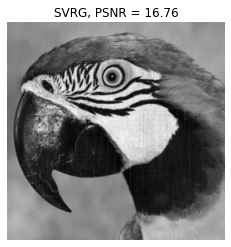

In [23]:
psnr_display(img_path='./data/Set12/07.png', output=svrg_out.reshape(height,width), title="SVRG", H=512, W=512)